In [29]:
import time
import concurrent.futures
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [66]:

class DiscreteOrdinates:
    def __init__(
        self,
        angles,
        weights,
        left_boundary,
        right_boundary,
        volumetric_source=0, 
        sigma_t=1,
        sigma_s=0,
        title_start="",
        x_start=0,
        x_end=1,
        n_surfaces=10,
    ):

        self.angles = angles
        self.weights = weights

        assert (
            isinstance(left_boundary, (int, float)) or left_boundary == "reflecting"
        ), "left_boundary must be a float or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            isinstance(right_boundary, (int, float)) or right_boundary == "reflecting"
        ), "right_boundary must be a float or 'reflecting'"
        self.right_boundary = right_boundary

        self.volumetric_source = volumetric_source
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.title_start = title_start
        self.x_start = x_start
        self.x_end = x_end
        self.n_surfaces = n_surfaces

        self.n_cells = n_surfaces - 1

        assert x_start < x_end, "x_start must be less than x_end"

        assert np.all(np.array(angles) != 0), "angles must not be zero"

        self.surface_x_pos = np.linspace(x_start, x_end, n_surfaces)

        self.delta_x = self.surface_x_pos[1] - self.surface_x_pos[0]

        self.cell_x_pos = np.linspace(
            x_start + self.delta_x / 2, x_end - self.delta_x / 2, self.n_cells
        )

        self.angular_fluxes_at_surfaces = np.zeros((n_surfaces, len(angles)))

        self.average_scalar_flux_at_cells = np.zeros(self.n_cells)

    def angular_flux(self, max_iter=20000, tol=1e-10):

        angular_flux_matrix_objs = {
            angle: AngularFluxMatrix(self, angle) for angle in self.angles
        }
        zero_block = np.zeros((self.n_surfaces, self.n_surfaces))
        number_of_angles = len(self.angles)

        block_matrix_components = (
            []
        )  # this will be a list of lists, where outer list components are rows
        for block_index, angle in enumerate(self.angles):
            submatrix = angular_flux_matrix_objs[angle].A_mat
            row = (
                block_index * [zero_block]
                + [submatrix]
                + (number_of_angles - block_index - 1) * [zero_block]
            )
            block_matrix_components.append(row)

        block_matrix = sp.sparse.bmat(block_matrix_components, format="csc")

        # apply neumman boundary condition to boundary
        # this could be better, but homework...
        if self.left_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_pos_angle * self.n_surfaces, nth_neg_angle * self.n_surfaces
                    ] = -1

        if self.right_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_neg_angle * self.n_surfaces + self.n_surfaces - 1,
                        nth_pos_angle * self.n_surfaces + self.n_surfaces - 1,
                    ] = -1

        if __debug__:
            full = block_matrix.toarray()

        start_time = time.time()
        for iter in range(max_iter):

            # scalar flux at each node

            old_scalar_flux = self.average_scalar_flux_at_cells.copy()

            # generate the b vector based on the old scalar flux
            b_vec = np.concatenate(
                [
                    angular_flux_matrix_objs[angle].b_vec(self.volumetric_source, old_scalar_flux)
                    for angle in self.angles
                ]
            )

            angular_flux_long = sp.sparse.linalg.spsolve(block_matrix, b_vec)

            # list where each element is a list of angular fluxes for each angle
            # the same order as self.angles
            self.angular_fluxes_at_surfaces = np.split(
                angular_flux_long, number_of_angles
            )

            self.angular_fluxes_at_cells = [
                angular_flux_matrix_objs[angle].average_angular_flux(
                    self.angular_fluxes_at_surfaces[i]
                )
                for i, angle in enumerate(self.angles)
            ]

            self.average_scalar_flux_at_cells = sum(
                angular_flux_at_angle * weight
                for angular_flux_at_angle, weight in zip(
                    self.angular_fluxes_at_cells, self.weights
                )
            )

            if np.allclose(old_scalar_flux, self.average_scalar_flux_at_cells, atol=tol):
                print(f"{self.title_start}: Converged after {iter} iterations")
                end_time = time.time()
                self.solver_time = end_time - start_time
                break

            if iter == max_iter - 1:
                end_time = time.time()
                self.solver_time = end_time - start_time
                print(f"{self.title_start}: Did not converge after {iter} iterations")

        return self.average_scalar_flux_at_cells

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(
            self.cell_x_pos,
            self.average_scalar_flux_at_cells,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_surfaces):
            ax.scatter(self.surface_x_pos, angular_fluxes, label=rf"$\psi$ surf $\mu=${angle:.2f}", marker="x")

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_cells):
            ax.scatter(
                self.cell_x_pos,
                angular_fluxes,
                label=rf"$\langle \psi \rangle$ cell at $\mu=${angle:.2f}",
                marker="o",
            )

        # ax.set_ylabel(r"$\langle \phi \rangle$")
        ax.set_xlabel("x")
        ax.legend()
        ax.set_title(self.title_start)

        return fig, ax
    
    def angular_flux_at_xloc(self, xloc):
        # find nearest cell
        cell_index = np.argmin(np.abs(self.cell_x_pos - xloc))
        
        angular_flux_per_angle = np.array([angular_flux[cell_index] for angular_flux in self.angular_fluxes_at_cells])
        
        return self.angles, angular_flux_per_angle
    
    def current(self):
        scalar_flux_derivative = np.gradient(self.average_scalar_flux_at_cells, self.cell_x_pos)
        transport_xs = self.sigma_t - 0 # since Sigma_s1 = 0
        diffusion_coeff = 1 / 3 / transport_xs
        current = -diffusion_coeff * scalar_flux_derivative
        return self.cell_x_pos, current
        

class AngularFluxMatrix:
    def __init__(self, discrete_ordinates: DiscreteOrdinates, mu):
        self.mu = mu
        self.discrete_ordinates: DiscreteOrdinates = discrete_ordinates

        self.sign_of_direction = np.sign(mu)
        self.surface_angular_flux = np.zeros(self.discrete_ordinates.n_surfaces)
        self.cell_averaged_angular_flux = np.zeros(self.discrete_ordinates.n_cells)

        self.tau_coeff = (
            self.discrete_ordinates.sigma_t
            * self.sign_of_direction
            * self.discrete_ordinates.delta_x
            / self.mu
        )
        self.exp_term = np.exp(-self.tau_coeff)

        self.diag_index = int(-1 * self.sign_of_direction)

        self.A_mat = sp.sparse.diags(
            [1, -self.exp_term],
            [0, self.diag_index],
            shape=(
                self.discrete_ordinates.n_surfaces,
                self.discrete_ordinates.n_surfaces,
            ),
            format="lil",
        )
        
    def b_vec(self, cell_source, scalar_flux_at_cell):
        self.source_at_cell = [
            (cell_source +  scalar_flux * self.discrete_ordinates.sigma_s) / 2
            for scalar_flux in scalar_flux_at_cell
        ]
        self.decay_coeff = 1 / (self.discrete_ordinates.sigma_t) * (1 - self.exp_term)
        source_at_cell_with_decay = [source * self.decay_coeff for source in self.source_at_cell]
        if self.sign_of_direction > 0:
            if isinstance(self.discrete_ordinates.left_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.left_boundary
            else:
                psi_initial = 0
            return [psi_initial] + source_at_cell_with_decay

        elif self.sign_of_direction < 0:
            if isinstance(self.discrete_ordinates.right_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.right_boundary
            else:
                psi_initial = 0
            return source_at_cell_with_decay + [psi_initial]

        else:
            raise ValueError("Direction must be positive or negative")
        
    def average_angular_flux(self, angular_flux_surface):
        # this is really bad code design (dependent on self.source_at_cell/decay_coeff)
        # , but the source at the cell was set up
        # when the b vector was generated...
        # That is, b_vec must have already been run
        
        # A_coeff = lambda i : self.source_at_cell[i] / self.discrete_ordinates.sigma_t
        sigma_s = self.discrete_ordinates.sigma_s
        volumetric_source = self.discrete_ordinates.volumetric_source
        old_scalar_flux = self.discrete_ordinates.average_scalar_flux_at_cells
        A_coeff = lambda i : (sigma_s * old_scalar_flux[i] + volumetric_source) / 2 / self.discrete_ordinates.sigma_t
        B_coeff = self.mu / (self.discrete_ordinates.sigma_t * -1) # self.discrete_ordinates.delta_x) # I thought it was delta x instead of 1, but these answers make more sense
        
        angular_flux_cell_average = np.zeros(self.discrete_ordinates.n_cells)
        for i in range(1, self.discrete_ordinates.n_surfaces):
            flux_left = angular_flux_surface[i - 1]
            flux_right = angular_flux_surface[i]
            
            angular_flux_cell_average[i - 1] = A_coeff(i - 1) + B_coeff * (flux_right - flux_left)
            
        return angular_flux_cell_average

In [31]:
# Homework 2:
# sigma_s = 1
# weights = [1, 1]
# a = [[1, -1], weights, 1, 0, 0, 1, sigma_s, "a"]
# b = [[1, -1], weights, 0, 1, 0, 1, sigma_s, "b"]
# c = [[1, -1], weights, 1, 1, 0, 1, sigma_s, "c"]
# d = [[0.25, -0.25], weights, 1, 1, 0, 1, sigma_s, "d"]
# e = [[0.25, -0.25], weights, 1, 1, 0, 4, sigma_s, "e"]
# f = [[1, -1], weights, 1, 0, 0, 0.1, sigma_s, "f"]

# for i in [a, b, c, d, e, f]:
#     s = DiscreteOrdinates(*i)
#     s.angular_flux()
#     s.plot()
# DiscreteOrdinates(*f).angular_flux()

test: Converged after 11 iterations


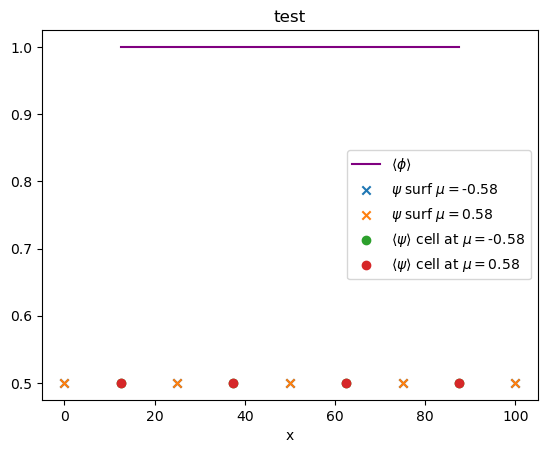

In [32]:
# Problem 1:

number_of_directions = 2
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)
solver = DiscreteOrdinates(
    angles=list(angles),
    weights=list(weights),
    left_boundary="reflecting",
    right_boundary="reflecting",
    volumetric_source=1,
    sigma_t=1.5,
    sigma_s=0.5,
    title_start="test",
    x_end=100,
    n_surfaces= 5
)
solver.angular_flux();
solver.plot();


Prob 1 Scattering: 0: Converged after 1 iterations
Prob 1 Scattering: 0.0001: Converged after 2 iterations
Prob 1 Scattering: 0.001: Converged after 2 iterations
Prob 1 Scattering: 0.01: Converged after 3 iterations
Prob 1 Scattering: 0.1: Converged after 5 iterations
Prob 1 Scattering: 0.5: Converged after 16 iterations
Prob 1 Scattering: 0.9: Converged after 88 iterations
Prob 1 Scattering: 0.99: Converged after 688 iterations
Prob 1 Scattering: 0.999: Converged after 4613 iterations


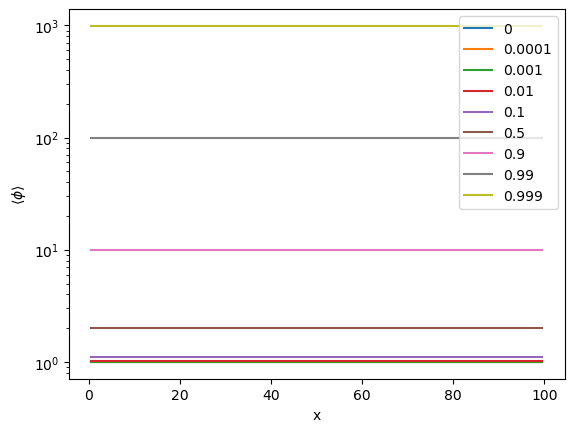

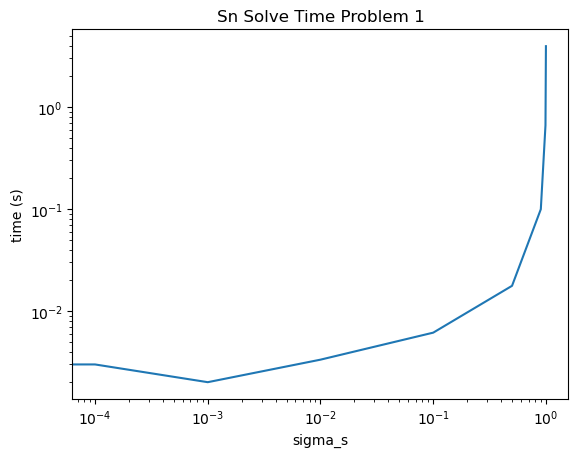

In [ ]:
fig, ax = plt.subplots()
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999]#, 0.9999, 1]
solve_times = []
number_of_directions = 8
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)
for sigma_scatter in sigma_scatters:
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary="reflecting",
        right_boundary="reflecting",
        volumetric_source=1,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start=f"Prob 1 Scattering: {sigma_scatter}",
        x_end=100,
        n_surfaces= 101
    )
    angular_flux = solver.angular_flux()
    ax.plot(solver.cell_x_pos, angular_flux, label=sigma_scatter)
    solve_times.append(solver.solver_time)

fig_time, ax_time = plt.subplots()
ax_time.plot(sigma_scatters, solve_times)
ax_time.set_xlabel("sigma_s")
ax_time.set_ylabel("time (s)")
ax_time.set_yscale("log")
ax_time.set_xscale("log")
ax_time.set_title("Sn Solve Time Problem 1")

ax.legend()
ax.set_xlabel("x")
ax.set_ylabel(r"$\langle \phi \rangle$")
ax.set_yscale("log")

<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:44: SyntaxWarning: invalid escape sequence '\S'
<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:44: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\2316260731.py:39: SyntaxWarning: invalid escape sequence '\S'
  ax.legend(title="$\Sigma_s$");
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\2316260731.py:44: SyntaxWarning: invalid escape sequence '\S'
  ax_current.legend(title="$\Sigma_s$");


2: 0: Converged after 1 iterations
2: 0.0001: Converged after 2 iterations
2: 0.001: Converged after 3 iterations
2: 0.01: Converged after 4 iterations
2: 0.1: Converged after 8 iterations
2: 0.5: Converged after 25 iterations
2: 0.9: Converged after 148 iterations
2: 0.99: Converged after 1257 iterations
2: 0.999: Converged after 4409 iterations
2: 0.9999: Converged after 7755 iterations
2: 1: Converged after 8661 iterations


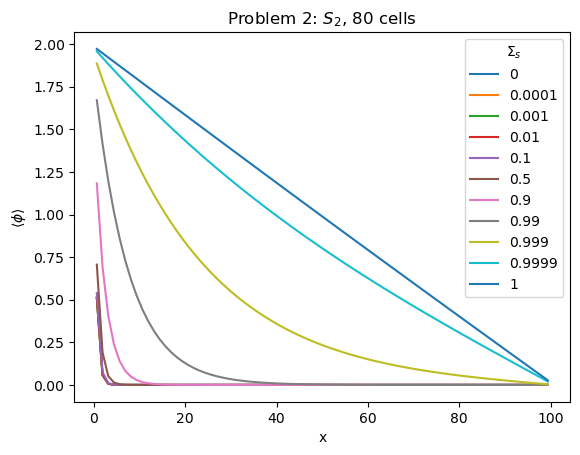

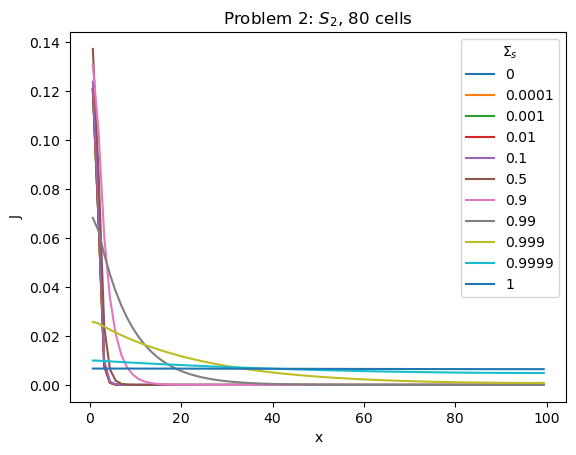

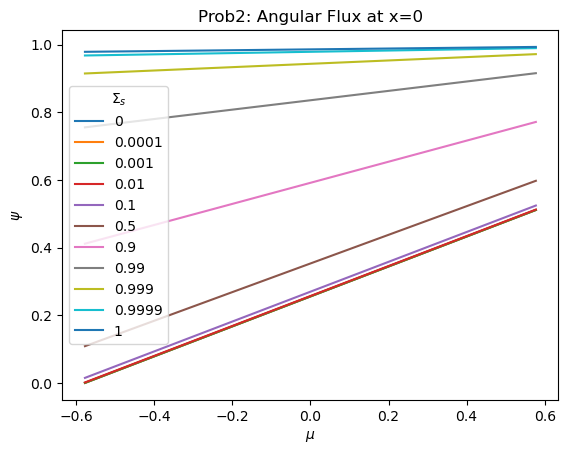

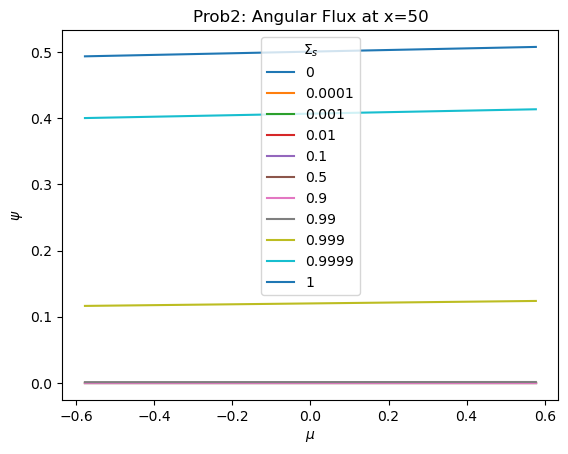

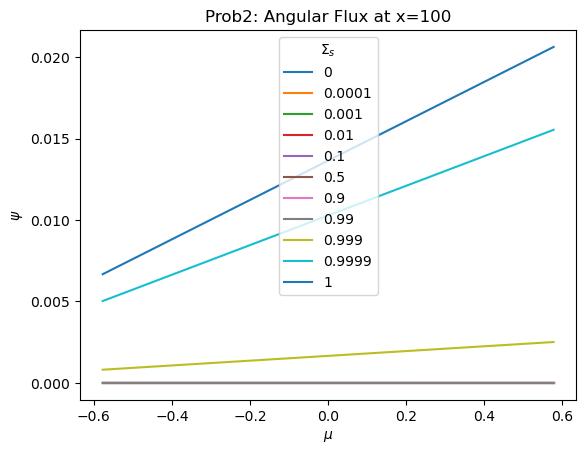

In [69]:
# Problem 2 make sure it works with different sigma scatters
number_of_directions = 2
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)
n_cells = 80
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]
# sigma_scatters = [0, 0.5, 1]
# sigma_scatters = [0, 0.1, 0.5, 0.99, 1]
fig, ax = plt.subplots()
fig_current, ax_current = plt.subplots()
fig_angular_flux0, ax_angular_flux0 = plt.subplots()
fig_angular_flux50, ax_angular_flux50 = plt.subplots()
fig_angular_flux100, ax_angular_flux100 = plt.subplots()
for sigma_scatter in sigma_scatters:
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=weights,
        left_boundary=1,
        right_boundary=0,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start=f"2: {sigma_scatter}",
        x_end=100,
        n_surfaces=n_cells + 1
    )
    flux = solver.angular_flux();
    # solver.plot();
    ax.plot(solver.cell_x_pos, flux, label=sigma_scatter)
    angles, angular_flux = solver.angular_flux_at_xloc(0)
    ax_angular_flux0.plot(angles, angular_flux, label=sigma_scatter)
    angles, angular_flux = solver.angular_flux_at_xloc(50)
    ax_angular_flux50.plot(angles, angular_flux, label=sigma_scatter)
    angles, angular_flux = solver.angular_flux_at_xloc(100)
    ax_angular_flux100.plot(angles, angular_flux, label=sigma_scatter)
    
    x, current = solver.current()
    ax_current.plot(x, current, label=sigma_scatter)
    
ax.legend(title="$\Sigma_s$");
ax.set_xlabel("x");
ax.set_ylabel(r"$\langle \phi \rangle$");
ax.set_title(rf"Problem 2: $S_{{{number_of_directions}}}$, {n_cells} cells");

ax_current.legend(title="$\Sigma_s$");
ax_current.set_xlabel("x");
ax_current.set_ylabel("J");
ax_current.set_title(rf"Problem 2: $S_{{{number_of_directions}}}$, {n_cells} cells");

ax_angular_flux0.legend(title=r"$\Sigma_s$");
ax_angular_flux0.set_xlabel(r"$\mu$");
ax_angular_flux0.set_ylabel(r"$\psi$");
ax_angular_flux0.set_title("Prob2: Angular Flux at x=0");

ax_angular_flux50.legend(title=r"$\Sigma_s$");
ax_angular_flux50.set_xlabel(r"$\mu$");
ax_angular_flux50.set_ylabel(r"$\psi$");
ax_angular_flux50.set_title("Prob2: Angular Flux at x=50");

ax_angular_flux100.legend(title=r"$\Sigma_s$");
ax_angular_flux100.set_xlabel(r"$\mu$");
ax_angular_flux100.set_ylabel(r"$\psi$");
ax_angular_flux100.set_title("Prob2: Angular Flux at x=100");

<>:51: SyntaxWarning: invalid escape sequence '\S'
<>:56: SyntaxWarning: invalid escape sequence '\S'
<>:51: SyntaxWarning: invalid escape sequence '\S'
<>:56: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\4061415204.py:51: SyntaxWarning: invalid escape sequence '\S'
  ax.legend(title="$\Sigma_s$");
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\4061415204.py:56: SyntaxWarning: invalid escape sequence '\S'
  ax_error.legend(title="$\Sigma_s$");


2: 0: Converged after 1 iterations
2: 2 0: Converged after 1 iterations
2: 4 0: Converged after 1 iterations
2: 8 0: Converged after 1 iterations
2: 16 0: Converged after 1 iterations
2: 32 0: Converged after 1 iterations
2: 0.0001: Converged after 2 iterations
2: 2 0.0001: Converged after 2 iterations
2: 4 0.0001: Converged after 2 iterations
2: 8 0.0001: Converged after 2 iterations
2: 16 0.0001: Converged after 2 iterations
2: 32 0.0001: Converged after 2 iterations
2: 0.001: Converged after 2 iterations
2: 2 0.001: Converged after 2 iterations
2: 4 0.001: Converged after 2 iterations
2: 8 0.001: Converged after 2 iterations
2: 16 0.001: Converged after 2 iterations
2: 32 0.001: Converged after 2 iterations
2: 0.01: Converged after 3 iterations
2: 2 0.01: Converged after 4 iterations
2: 4 0.01: Converged after 3 iterations
2: 8 0.01: Converged after 3 iterations
2: 16 0.01: Converged after 3 iterations
2: 32 0.01: Converged after 3 iterations
2: 0.1: Converged after 6 iterations
2: 

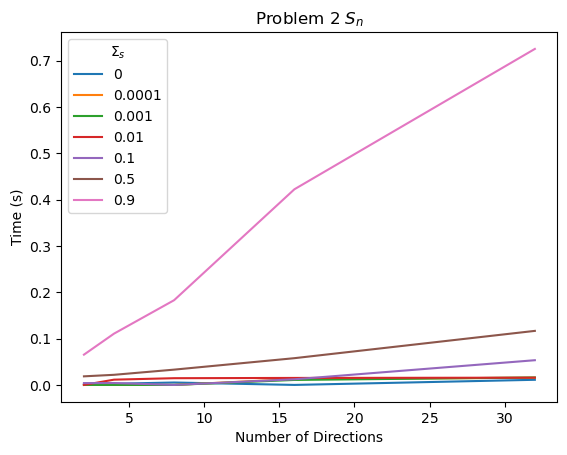

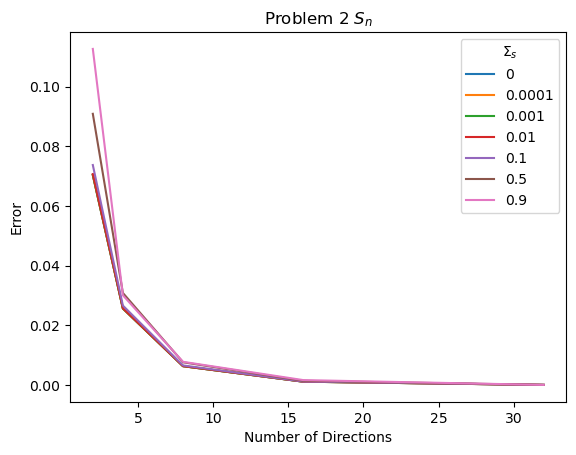

In [89]:
# Problem 2 testing directions
number_of_cells = 160
number_of_directions = [2, 4, 8, 16, 32]
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]

fig, ax = plt.subplots()
fig_eror, ax_error = plt.subplots()

for sigma_scatter in sigma_scatters:
    solution_times = []
    errors = []
    
    angles, weights = np.polynomial.legendre.leggauss(32)
    truth_solver = DiscreteOrdinates(
        angles=list(angles),
        weights=weights,
        left_boundary=1,
        right_boundary=0,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start=f"2: {sigma_scatter}",
        x_end=100,
        n_surfaces=number_of_cells + 1
    )
    truth = truth_solver.angular_flux()
    
    for number_of_direction in number_of_directions:
        angles, weights = np.polynomial.legendre.leggauss(number_of_direction)
        solver = DiscreteOrdinates(
            angles=list(angles),
            weights=weights,
            left_boundary=1,
            right_boundary=0,
            volumetric_source=0,
            sigma_t=1,
            sigma_s=sigma_scatter,
            title_start=f"2: {number_of_direction} {sigma_scatter}",
            x_end=100,
            n_surfaces=number_of_cells + 1
        )
        angular_flux = solver.angular_flux()
        solution_times.append(solver.solver_time)
        
        error = np.linalg.norm(truth - angular_flux)
        errors.append(error)

    ax.plot(number_of_directions, solution_times, label=sigma_scatter)
    ax_error.plot(number_of_directions, errors, label=sigma_scatter)
    
ax.legend(title="$\Sigma_s$");
ax.set_xlabel("Number of Directions");
ax.set_ylabel("Time (s)");
ax.set_title("Problem 2 $S_n$");

ax_error.legend(title="$\Sigma_s$");
ax_error.set_xlabel("Number of Directions");
ax_error.set_ylabel("Error");
ax_error.set_title("Problem 2 $S_n$");

In [ ]:
# Problem 2, timing test with different resolutions
number_of_cells = [10, 40, 160, 640, 2560, 10240]
number_of_directions = [2, 4, 8, 16, 32, 64]
time_limit = 30 # seconds
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]

for sigma_scatter in sigma_scatters:
    time_dict = {n_cell : {} for n_cell in number_of_cells}

    for n_cells in number_of_cells:
        for n_directions in number_of_directions:
            angles, weights = np.polynomial.legendre.leggauss(n_directions)
            solver = DiscreteOrdinates(
                angles=list(angles),
                weights=list(weights),
                left_boundary=1,
                right_boundary=0,
                volumetric_source=0,
                sigma_t=1,
                sigma_s=sigma_scatter,
                title_start=f"n={n_cells}, S_n={n_directions}",
                x_end=100,
                n_surfaces=n_cells + 1
            )
            
            def time_solver():
                start = time.time()
                solver.angular_flux();
                end = time.time()
                return end - start
            
            # this just sets a timelimit
            # I don't want to run in parallel because memory is the main issue
            with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(time_solver)
                try:
                    time_dict[n_cells][n_directions] = future.result(timeout=time_limit)
                except concurrent.futures.TimeoutError:
                    time_dict[n_cells][n_directions] = f"Timeout: {time_limit}s"
                    break
                except:
                    time_dict[n_cells][n_directions] = "Error"
                    break
                    
    time_df2 = pd.DataFrame(time_dict).T
    time_df2.to_csv(f"time2_sigmas{sigma_scatter}.csv")
    # time_df2

n=10, S_n=2: Converged after 1 iterations
n=10, S_n=4: Converged after 1 iterations
n=10, S_n=8: Converged after 1 iterations
n=10, S_n=16: Converged after 1 iterations
n=10, S_n=32: Converged after 1 iterations
n=10, S_n=64: Converged after 1 iterations
n=40, S_n=2: Converged after 1 iterations
n=40, S_n=4: Converged after 1 iterations
n=40, S_n=8: Converged after 1 iterations
n=40, S_n=16: Converged after 1 iterations
n=40, S_n=32: Converged after 1 iterations
n=40, S_n=64: Converged after 1 iterations
n=160, S_n=2: Converged after 1 iterations
n=160, S_n=4: Converged after 1 iterations
n=160, S_n=8: Converged after 1 iterations
n=160, S_n=16: Converged after 1 iterations
n=160, S_n=32: Converged after 1 iterations
n=160, S_n=64: Converged after 1 iterations
n=640, S_n=2: Converged after 1 iterations
n=640, S_n=4: Converged after 1 iterations
n=640, S_n=8: Converged after 1 iterations
n=640, S_n=16: Converged after 1 iterations
n=640, S_n=32: Converged after 1 iterations
n=640, S_n=6

test3: Converged after 1 iterations
test3: Converged after 2 iterations
test3: Converged after 2 iterations
test3: Converged after 3 iterations
test3: Converged after 5 iterations
test3: Converged after 16 iterations
test3: Converged after 88 iterations
test3: Converged after 687 iterations
test3: Converged after 4038 iterations
test3: Converged after 11071 iterations
test3: Converged after 14410 iterations


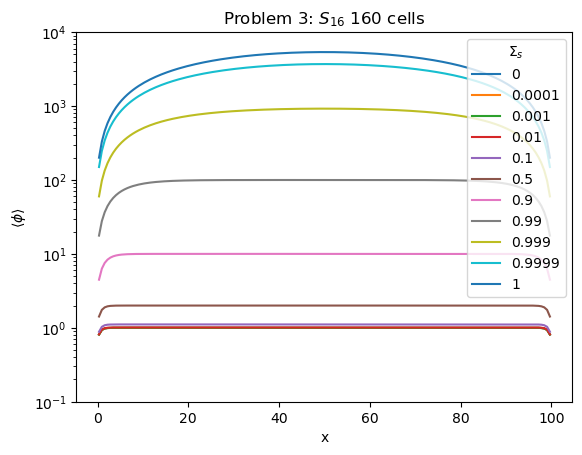

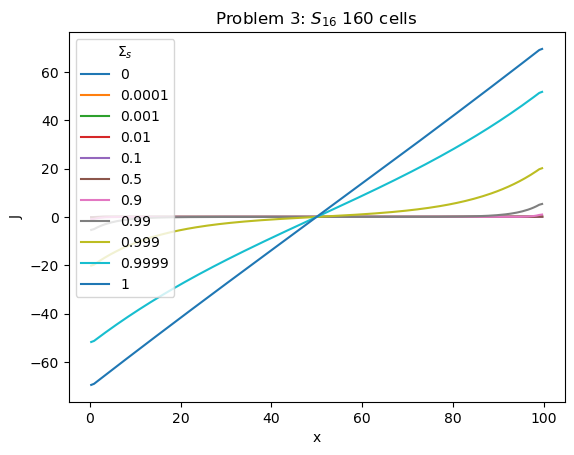

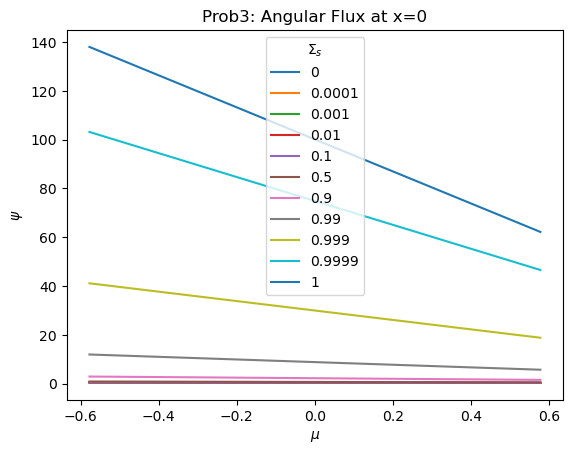

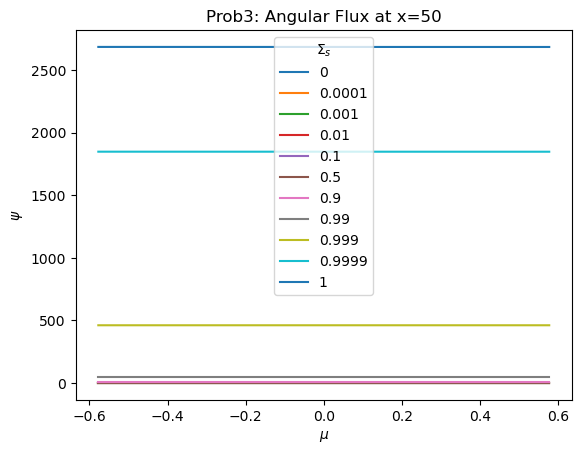

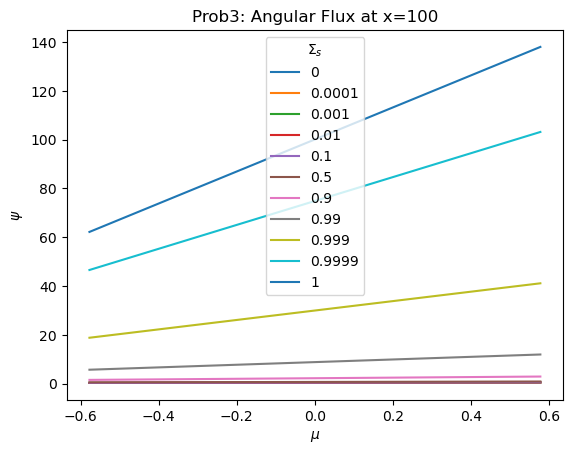

In [76]:
# Problem 3
n_cells = 160
number_of_directions = 16
angles, weights = np.polynomial.legendre.leggauss(2)
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]
fig, ax = plt.subplots()
fig_current, ax_current = plt.subplots()
fig0, ax0 = plt.subplots()
fig50, ax50 = plt.subplots()
fig100, ax100 = plt.subplots()
for sigma_scatter in sigma_scatters:
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary=0,
        right_boundary=0,
        volumetric_source=1,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start="test3",
        x_end=100,
        n_surfaces=n_cells + 1
    )
    flux = solver.angular_flux();
    ax.plot(solver.cell_x_pos, flux, label=sigma_scatter)
    
    angles, angular_flux = solver.angular_flux_at_xloc(0)
    ax0.plot(angles, angular_flux, label=sigma_scatter)
    angles, angular_flux = solver.angular_flux_at_xloc(50)
    ax50.plot(angles, angular_flux, label=sigma_scatter)
    angles, angular_flux = solver.angular_flux_at_xloc(100)
    ax100.plot(angles, angular_flux, label=sigma_scatter)
    
    x, current = solver.current()
    ax_current.plot(x, current, label=sigma_scatter)

ax.legend(title = r"$\Sigma_s$");
ax.set_xlabel("x");
ax.set_ylabel(r"$\langle \phi \rangle$");
ax.set_yscale("log");
ax.set_title(f"Problem 3: $S_{{{number_of_directions}}}$ {n_cells} cells");
ax.set_ylim(1e-1, 1e4)

ax_current.legend(title = r"$\Sigma_s$");
ax_current.set_xlabel("x");
ax_current.set_ylabel("J");
ax_current.set_title(f"Problem 3: $S_{{{number_of_directions}}}$ {n_cells} cells");

ax0.legend(title = r"$\Sigma_s$");
ax0.set_xlabel(r"$\mu$");
ax0.set_ylabel(r"$\psi$");
ax0.set_title("Prob3: Angular Flux at x=0");

ax50.legend(title = r"$\Sigma_s$");
ax50.set_xlabel(r"$\mu$");
ax50.set_ylabel(r"$\psi$");
ax50.set_title("Prob3: Angular Flux at x=50");

ax100.legend(title = r"$\Sigma_s$");
ax100.set_xlabel(r"$\mu$");
ax100.set_ylabel(r"$\psi$");
ax100.set_title("Prob3: Angular Flux at x=100");

<>:48: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\S'
<>:48: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\229081490.py:48: SyntaxWarning: invalid escape sequence '\S'
  ax.legend(title="$\Sigma_s$");
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\229081490.py:53: SyntaxWarning: invalid escape sequence '\S'
  ax_error.legend(title="$\Sigma_s$");


3: 0: Converged after 1 iterations
3: 2 0: Converged after 1 iterations
3: 4 0: Converged after 1 iterations
3: 8 0: Converged after 1 iterations
3: 16 0: Converged after 1 iterations
3: 32 0: Converged after 1 iterations
3: 0.0001: Converged after 2 iterations
3: 2 0.0001: Converged after 2 iterations
3: 4 0.0001: Converged after 2 iterations
3: 8 0.0001: Converged after 2 iterations
3: 16 0.0001: Converged after 2 iterations
3: 32 0.0001: Converged after 2 iterations
3: 0.001: Converged after 2 iterations
3: 2 0.001: Converged after 2 iterations
3: 4 0.001: Converged after 2 iterations
3: 8 0.001: Converged after 2 iterations
3: 16 0.001: Converged after 2 iterations
3: 32 0.001: Converged after 2 iterations
3: 0.01: Converged after 3 iterations
3: 2 0.01: Converged after 3 iterations
3: 4 0.01: Converged after 3 iterations
3: 8 0.01: Converged after 3 iterations
3: 16 0.01: Converged after 3 iterations
3: 32 0.01: Converged after 3 iterations
3: 0.1: Converged after 5 iterations
3: 

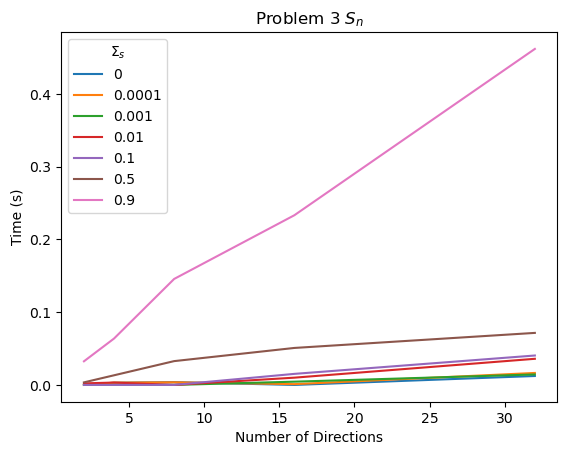

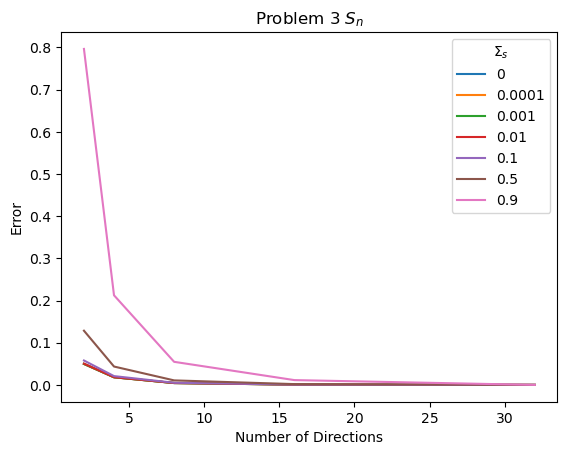

In [91]:
# Problem 3 testing directions
number_of_cells = 160
number_of_directions = [2, 4, 8, 16, 32]
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]

fig, ax = plt.subplots()
fig_error, ax_error = plt.subplots()

for sigma_scatter in sigma_scatters:
    solution_times = []
    errors = []
    
    angles, weights = np.polynomial.legendre.leggauss(32)
    truth_solver = DiscreteOrdinates(
        angles=list(angles),
        weights=weights,
        left_boundary=0,
        right_boundary=0,
        volumetric_source=1,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start=f"3: {sigma_scatter}",
        x_end=100,
        n_surfaces=number_of_cells + 1
    )
    truth_flux = truth_solver.angular_flux()
    for number_of_direction in number_of_directions:
        angles, weights = np.polynomial.legendre.leggauss(number_of_direction)
        solver = DiscreteOrdinates(
            angles=list(angles),
            weights=weights,
            left_boundary=0,
            right_boundary=0,
            volumetric_source=1,
            sigma_t=1,
            sigma_s=sigma_scatter,
            title_start=f"3: {number_of_direction} {sigma_scatter}",
            x_end=100,
            n_surfaces=number_of_cells + 1
        )
        angular_flux = solver.angular_flux()
        solution_times.append(solver.solver_time)
        errors.append(np.linalg.norm(truth_flux - angular_flux))

    ax.plot(number_of_directions, solution_times, label=sigma_scatter)
    ax_error.plot(number_of_directions, errors, label=sigma_scatter)
    
ax.legend(title="$\Sigma_s$");
ax.set_xlabel("Number of Directions");
ax.set_ylabel("Time (s)");
ax.set_title("Problem 3 $S_n$");

ax_error.legend(title="$\Sigma_s$");
ax_error.set_xlabel("Number of Directions");
ax_error.set_ylabel("Error");
ax_error.set_title("Problem 3 $S_n$");

In [ ]:
# Problem 3 testing resolution
number_of_cells = [10, 40, 160, 640, 2560, 10240]
number_of_directions = [2, 4, 8, 16, 32, 64]
time_limit = 30  # seconds
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]

for sigma_scatter in sigma_scatters:
    time_dict = {n_cell: {} for n_cell in number_of_cells}
    

    for n_cells in number_of_cells:
        for n_directions in number_of_directions:
            angles, weights = np.polynomial.legendre.leggauss(n_directions)
            solver = DiscreteOrdinates(
                angles=list(angles),
                weights=list(weights),
                left_boundary=0,
                right_boundary=0,
                volumetric_source=0,
                sigma_t=1,
                sigma_s=sigma_scatter,
                title_start=f"n={n_cells}, S_n={n_directions}",
                x_end=100,
                n_surfaces=n_cells + 1,
            )

            def time_solver():
                start = time.time()
                solver.angular_flux()
                end = time.time()
                return end - start

            # this just sets a timelimit
            # I don't want to run in parallel because memory is the main issue
            with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(time_solver)
                try:
                    time_dict[n_cells][n_directions] = future.result(timeout=time_limit)
                except concurrent.futures.TimeoutError:
                    time_dict[n_cells][n_directions] = f"Timeout: {time_limit}s"
                    break
                except:
                    time_dict[n_cells][n_directions] = "Error"
                    break

    time_df3 = pd.DataFrame(time_dict).T
    time_df3.to_csv(f"time3_sigmas{sigma_scatter}.csv")

n=10, S_n=2: Converged after 1 iterations
n=10, S_n=4: Converged after 1 iterations
n=10, S_n=8: Converged after 1 iterations
n=10, S_n=16: Converged after 1 iterations
n=10, S_n=32: Converged after 1 iterations
n=10, S_n=64: Converged after 1 iterations
n=40, S_n=2: Converged after 1 iterations
n=40, S_n=4: Converged after 1 iterations
n=40, S_n=8: Converged after 1 iterations
n=40, S_n=16: Converged after 1 iterations
n=40, S_n=32: Converged after 1 iterations
n=40, S_n=64: Converged after 1 iterations
n=160, S_n=2: Converged after 1 iterations
n=160, S_n=4: Converged after 1 iterations
n=160, S_n=8: Converged after 1 iterations
n=160, S_n=16: Converged after 1 iterations
n=160, S_n=32: Converged after 1 iterations
n=160, S_n=64: Converged after 1 iterations
n=640, S_n=2: Converged after 1 iterations
n=640, S_n=4: Converged after 1 iterations
n=640, S_n=8: Converged after 1 iterations
n=640, S_n=16: Converged after 1 iterations
n=640, S_n=32: Converged after 1 iterations
n=640, S_n=6